<a href="https://colab.research.google.com/github/usm-cos-432/InClass/blob/master/chapter6/cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [4]:
!pip install d2l==0.14.4


     |████████████████████████████████| 61kB 5.2MB/s 


# CIFAR 10 Lab

We explore model development for the CIFAR 10 data set.

In [43]:
from d2l import torch as d2l
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import transforms
from torch.utils import data
from torch.utils.data.sampler import SubsetRandomSampler

In [119]:
def load_data_cifar10(batch_size, resize=None): 
    """Download the Fashion-MNIST dataset and then load it into memory."""
    transformer = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    if resize:
        transformer.insert(0, transforms.Resize(resize))
    
    cifar10_train = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transformer)
    cifar10_test = torchvision.datasets.CIFAR10(root="../data", train=False, transform=transformer, download=True)
    indices = list(range(len(cifar10_train)))
    np.random.shuffle(indices)
    split = int(np.floor(0.95 * len(cifar10_train)))
    cifar10_train_sample = SubsetRandomSampler(indices[split:])
    cifar10_valid_sample = SubsetRandomSampler(indices[:split])

    return (data.DataLoader(cifar10_train, batch_size, sampler=cifar10_train_sample),
            data.DataLoader(cifar10_train, batch_size, sampler=cifar10_valid_sample),
            data.DataLoader(cifar10_test, batch_size, shuffle=False))

In [ ]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater): 
    """Train a model (defined in Chapter 3)."""
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.0, 1.0],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = d2l.train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = d2l.evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))

In [16]:
def get_cifar10_labels(labels):  #@save
    """Return text labels for the Fashion-MNIST dataset."""
    text_labels = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    return [text_labels[int(i)] for i in labels]

In [32]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=2.5):  #@save
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        img = img / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        npimg = np.transpose(npimg,(1,2,0)) 
        ax.imshow(npimg)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

Files already downloaded and verified


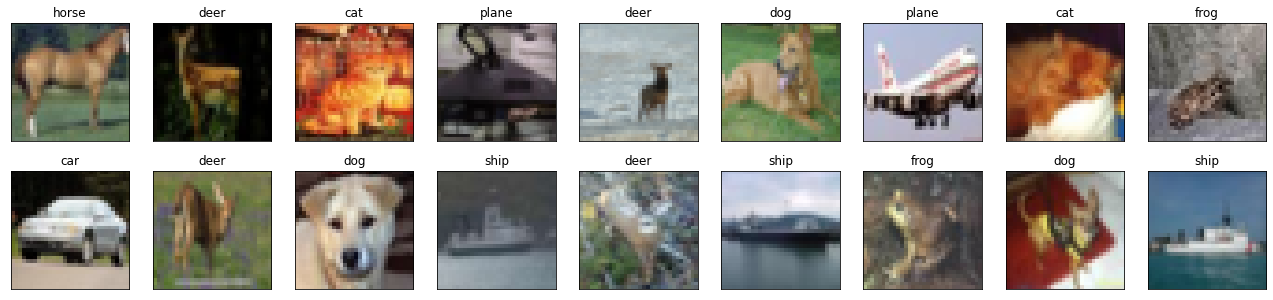

In [35]:
batch_size=24
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
train_iter, valid_iter, test_iter = load_data_cifar10(batch_size)
X, y = next(iter(train_iter))

show_images(X, 2, 9, titles=get_cifar10_labels(y));


In [108]:
X.shape

torch.Size([256, 3, 32, 32])

## Model

As compared with our concise implementation
of softmax regression implementation
(:numref:`sec_softmax_concise`),
the only difference is that we add
*two* fully-connected layers
(previously, we added *one*).
The first is our hidden layer,
which contains 256 hidden units
and applies the ReLU activation function.
The second is our output layer.


In [36]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()



The training loop is exactly the same
as when we implemented softmax regression.
This modularity enables us to separate
matters concerning the model architecture
from orthogonal considerations.


In [112]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr,
              device=d2l.try_gpu()):
    """Train a model with a GPU (defined in Chapter 6)."""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            net.train()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_loss = metric[0]/metric[2]
            train_acc = metric[1]/metric[2]
            if (i + 1) % 50 == 0:
                animator.add(epoch + i / len(train_iter),
                             (train_loss, train_acc, None))
        test_acc = evaluate_accuracy_gpu2(net, test_iter, device)
        test_acc = 0
        animator.add(epoch+1, (None, None, test_acc))
    print(f'loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

In [114]:
def accuracy(y_hat, y):  #@save
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = d2l.argmax(y_hat, axis=1)           
    cmp = d2l.astype(y_hat, y.dtype) == y
    return float(d2l.reduce_sum(d2l.astype(cmp, y.dtype)))


In [85]:
X, y = next(iter(train_iter))
X, y = X.to('cuda:0'), y.to('cuda:0')
y_hat = net(X)
if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = d2l.argmax(y_hat, axis=1)  
cmp = d2l.astype(y_hat, y.dtype) == y
float(d2l.reduce_sum(d2l.astype(cmp, y.dtype)))

91.0

In [116]:
def evaluate_accuracy_gpu2(net, data_iter, device=None): #@save
    """Compute the accuracy for a model on a dataset using a GPU."""
    net.eval()  # Set the model to evaluation mode
    if not device:
        device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        metric.add(accuracy(net(X), y), d2l.size(y))
    return metric[0] / metric[1]

In [90]:
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr=lr)

loss 1.802, train acc 0.354, test acc 0.000
56936.8 examples/sec on cuda:0


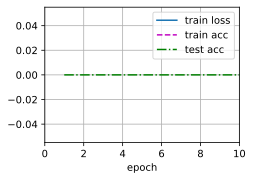

In [120]:
train_iter, valid_iter, test_iter = load_data_cifar10(batch_size)

train_ch6(net, train_iter, test_iter, num_epochs, lr)

In [103]:
print(evaluate_accuracy_gpu(net, train_iter))
print(d2l.evaluate_accuracy_gpu(net, test_iter))


start 0
start cuda:0
o device
in
reda
o device
in
reda
o device
in
reda
o device
in
reda
o device
in
reda
o device
in
reda
o device
in
reda
o device
in
reda
o device
in
reda
o device
in
reda
finished
0.2124


RuntimeError: ignored